## Agent Based Modeling (ABM): Forest Fire Model 1
-----------

This material is based on the previous version of CS108L, see https://cs4all.cs.unm.edu/cs108.html
- Credit to Prof. Melanie Moses, Dr. Irene Lee, Dr. Maureen Psaila-Dombrowski, Prof. Dave Ackley and collaborators (see website)

### Review: Computational Science 
- ABM is part of the much broader field of computational science (not computer science!)
- Computational science is the intersection of computer science, mathematices, and science (like biology, or chemistry, or physics)

<img src="https://raw.githubusercontent.com/jbschroder/CS108/main/lecture_images/venn_diagram.png" width="350">

### Review: Agent Based Modeling

<img src="https://raw.githubusercontent.com/jbschroder/CS108/main/lecture_images/agent_based_modeling.png" width="300">

### Learning Goals

1. Continue learning how to use Mesa ABM 
    1. How to use ABM
        - Conduct experiments by changing values and variables (like how flammable a tree is)
        - Collect and analyze results
    2. Learn how to modify ABM
    3. Learn how to create ABM
        
2. Continue practicing running multiple experiments with different numbers of steps and number of agents    
    
3. New: Forest fire model
    1. Agents are trees
    2. Trees are randomly scattered on a grid with a user-defined density
    3. Each step (iteration of the Runtime loop)
        - If a tree is on fire, all neighboring trees also catch fire
    
4. New: Collect statistics over time

### First, we have to make sure that Mesa is installed, and then import our basic packages
- Note that Pandas and Seaborn or "built-in" packages, so we only have to import them, not install them

In [1]:
! pip install mesa==2.1.1


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
%matplotlib inline

import mesa

# Data visualization tools.
import seaborn as sns

# Data manipulation and analysis.
import pandas as pd

import matplotlib.pyplot as plt


### Now, we can begin creating our forest fire model 

### First, we define  the TreeAgent (inherits from `mesa.Agent`)


- Each Step (iteration of the Runtime loop)
   - If a tree is on fire, all neighboring trees also catch fire
   - Remember that the model step calls each agent step in random order


In [116]:
# Create ABM

# 1. Define the Agent Abstraction
class TreeAgent(mesa.Agent):

    def __init__(self, model, pos):
        """
        Create a new tree.
        
        Parameters:
            model: the agent based model, within which this agent is acting
            
            pos: The tree's coordinates on the grid. Used as the unique_id
        """
        
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "No Fire"

    def step(self):
        """
        If the tree is on fire, spread it to `no fire` trees nearby.
        """
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "No Fire":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

### Next, we define our ForestFireModel 
1. Randomly place trees on a grid according to a `density`

   For each square on the grid
    - If a random number between 0 and 1 is below `density`
    - Then place a tree in that square

2. Store the spatial locations of the agents for animations in `agent_locations`

### This defines two more of our key abstractions:
1. This defines the environment where the agents (trees) exist
2. This also defines how to take a step (tick) forward in time


In [144]:
# 2. Define the Model (or environment) Abstraction for the Agents to live in
class ForestFireModel(mesa.Model):
    """
    Simple Forest Fire model.
    """

    def __init__(self, width, height, density):
        """
        Create a new forest fire model.

        Args:
            width, height: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        """
        # Set up model objects
        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.SingleGrid(width, height, torus=False)
        self.width = width
        self.height = height
        
        # Save the spatial location of the agents in this list
        self.agent_locations = []
        
        # Store the number of trees with no fire, yes on fire, burned out 
        self.no_fire = []
        self.yes_fire = []
        self.burned_out = []
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if self.random.random() < density:
                    # Create a tree
                    new_tree = TreeAgent(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[x][y] = new_tree
                    self.schedule.add(new_tree)
                    
        self.running = True

    def step(self):
        """
        Advance the model by one step.
        """
        self.schedule.step()
            
        # Store spatial locations, and whether a tree is on fire or not
        import numpy as np
        agent_counts = np.zeros((self.grid.width, self.grid.height))
        for cell_content, (x, y) in self.grid.coord_iter():
            if cell_content == None:
                # No tree here, label 0
                agent_counts[x][y] = 0
            else: 
                # Now, we know that this cell has a tree and that cell_content is a tree agent
                if cell_content.condition == "No Fire":
                    agent_counts[x][y] = 1
                elif cell_content.condition == "On Fire":
                    agent_counts[x][y] = 2
                elif cell_content.condition == "Burned Out":
                    agent_counts[x][y] = 3
                    
        self.agent_locations.append(agent_counts)
        
        # Count the number of trees with no fire, yes on fire, burned out 
        count_no_fire = 0
        count_yes_fire = 0
        count_burned_out = 0
        for tree in self.schedule.agents:
            if tree.condition == "No Fire":
                count_no_fire += 1
            elif tree.condition == "On Fire":
                count_yes_fire += 1    
            elif tree.condition == "Burned Out":
                count_burned_out += 1    
        ##
        self.no_fire.append(count_no_fire)
        self.yes_fire.append(count_yes_fire)
        self.burned_out.append(count_burned_out)


### The below cell will generate animations.  
- Run this cell, to declare (define) this function
- This function is provided for you.  You only need to know how to use it. It generate animations of your agents as they move around on the grid.

In [171]:
# Run this cell
def plot_agents(model):
    import numpy as np
    import seaborn as sns
    import matplotlib.animation
    import matplotlib.pyplot as plt
    import matplotlib
    
    try:
      # if in a notebook, do inline
      get_ipython().run_line_magic('matplotlib', 'inline')
    except:
      pass

    plt.rcParams['figure.dpi'] = 72
    plt.rcParams["animation.html"] = "jshtml" # javascript html writer
    plt.ioff() # Turn interactive mode off
    plt.rcParams["figure.figsize"] = [7, 7]

    
    fig, ax = plt.subplots()
    global counter 
    counter = 0
    
    def animate(t):
        global counter
        agent_counts = model.agent_locations[t]
        
        cmap_dict = {0: '#FFFFFF', 1: '#00e400', 2: '#ff0000', 3: '#544c4a'}
        cmap = matplotlib.colors.ListedColormap([cmap_dict[i] for i in range(4)])
        
        # Plot using seaborn
        if counter == 0:
            g = sns.heatmap(agent_counts, vmin=0, vmax=3, cmap=cmap, cbar=True, square=True, ax=ax)
            c_bar = ax.collections[0].colorbar
            c_bar.set_ticks([0.5, 1.15, 1.9, 2.65])
            c_bar.set_ticklabels(['Empty', 'Tree', 'On Fire', 'Burned Out'])
        else:
            g = sns.heatmap(agent_counts, vmin=0, vmax=3, cmap=cmap, cbar=False, square=True, ax=ax)

        g.figure.set_size_inches(7, 7)
        g.set(title="Forest Fire Model")
        counter = counter+1

        
    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(model.agent_locations), interval=200, repeat=False)
    return anim


## Running the model

Let's create a model with a 100 x 100 grid, and a tree density of 0.6. Remember, ForestFireModel takes the arguments *height*, *width*, *density*.

### Task: In the below cell, create an `AppleTradingModel` with 10 agents.
- Name your model `model`
- Then run that model for 10 steps
- Finally, run the animation cell below.  

### Task: Repeat this.  Observe how the pattern of agent movements changes every time.  
- Try more agents and more steps.  
- Observe how randomness works in practice!

In [172]:
fire_model = ForestFireModel(50, 50, 0.6)

In [173]:
for i in range(50):
    fire_model.step()

In [174]:
anim = plot_agents(fire_model)
anim

### Task: Run multiple experiments
- Copy/move your code for running multiple experiments into the below cell
- Make sure you track the number of apples for each agent, over all experiments in `all_agents_NumberApples`
- Run the model 100 times for 50 steps. Generate a Seaborn histogram

### Then, copy and paste your cells for running 100 times and plotting with Seaborn so that you  generate plots for
- 100 steps
- 200 steps
- 400 steps
- 800 steps

You'll need to copy and past 4 times, so that you can generate and see your results for all experiments.



Remember the data collector? Now we can put the data it collected into a pandas DataFrame:

In [123]:
results = pd.DataFrame({'No Fire': fire_model.no_fire, 'On Fire' : fire_model.yes_fire, 'Burned Out': fire_model.burned_out})

And chart it, to see the dynamics.

<AxesSubplot: xlabel='time', ylabel='number of trees'>

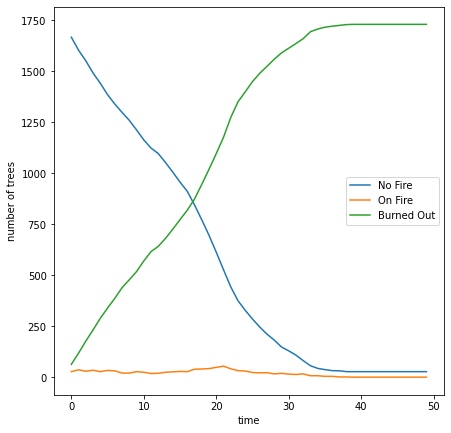

In [140]:
%matplotlib inline

results.plot(xlabel='time', ylabel='number of trees')

In this case, the fire burned itself out after about 90 steps, with many trees left unburned. 

You can try changing the density parameter and rerunning the code above, to see how different densities yield different dynamics. For example:

<AxesSubplot: xlabel='time', ylabel='number of trees'>

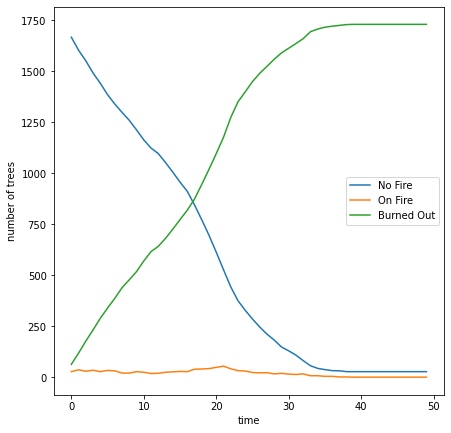

In [139]:
%matplotlib inline

fire_model = ForestFireModel(50, 50, 0.7)

for i in range(50):
    fire_model.step()

results = pd.DataFrame({'No Fire': fire_model.no_fire, 'On Fire' : fire_model.yes_fire, 'Burned Out': fire_model.burned_out})
results.plot(xlabel='time', ylabel='number of trees')

In [16]:
## Note, there is a criticality thing here, where if there are any trees still on fire, it keeps running.
## But it stops running once there are no more fires.

## Could have them run a variety of experiments for different densities and record

## the script version of this has a nice visualization

## can you visualize trees burning, burned out, not on fire? 

## be like last week.  have them run more experiments and interpret more data
#1.  intro model, run it by hand a few times, describe what you see with discussion template
#2.  then copy over language for number of agents and steps, run and put in discussion template
#3.  then modify to make more realistic, abstract away less things

      How long to run until steady state?

      add new list to track burned out...
         [ Have to delete, but not before copying over to solution and next lab ]
        
      You'll want to create this, and a solution file...   
        
      go to 75x75, 100x100
         be careful with animation 
         HW question: what is the max number of steps needed to reach steady state?
        
        
       try different columns of x for fire
       try just one tree, try middle column (x=49)

        if neighbor.condition == "No Fire":
            neighbor.condition = "On Fire"
        
        becomes
        
        if neighbor.condition == "No Fire":
            if self.random.random() < probability_tree_spreads:
                neighbor.condition = "On Fire"
            
        
        experiment with these some, write up.

IndentationError: unexpected indent (755126738.py, line 15)

In [ ]:
look for articles / videos to supplement


Discuss your homework in at least 500 words.  Have sections for 

1. Evidence acquisition 
     - Describe the experiments you conducted. Give all the details, number of agents, steps, abstractions used, and so on. 
     - You are describing application of a quantitative model (the agent based model)

2. Evidence evaluation 
    - Discuss your plots and any other results.  What did you find? 
    - You are communicating and representing quantitative information
    
3. Conclusion
    - What can you conclude?  
    - What is still unexplained? 
    - You've compared two models (one where agents can move, and one where they cannot).  
        - Does this tell you anything how trading in the real world might work?  
        - What details are missing in the model that you think are most needed?


For this homework, pay attention to these questions.
- Compare the cases where agents cannot move in space versus when they can move in space
    - That is, compare the results from the last lab, to this lab
- What was the effect of allowing for movement, and restricting trading to be only between agents on the same square?
    - Did the speed at which apples were traded change?

### Homework Discussion Goes here

### Homework Submission Instructions

### The homework submission instructions are different this week. 

### Download your notebook as an ".ipynb" file, and upload the ipynb file as your assignment to Canvas.

### Do not upload a .py file